<a href="https://colab.research.google.com/github/gilbertycc/myCodes/blob/main/stockTA_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Debug] *****squarify not found. Installing squarify...*****


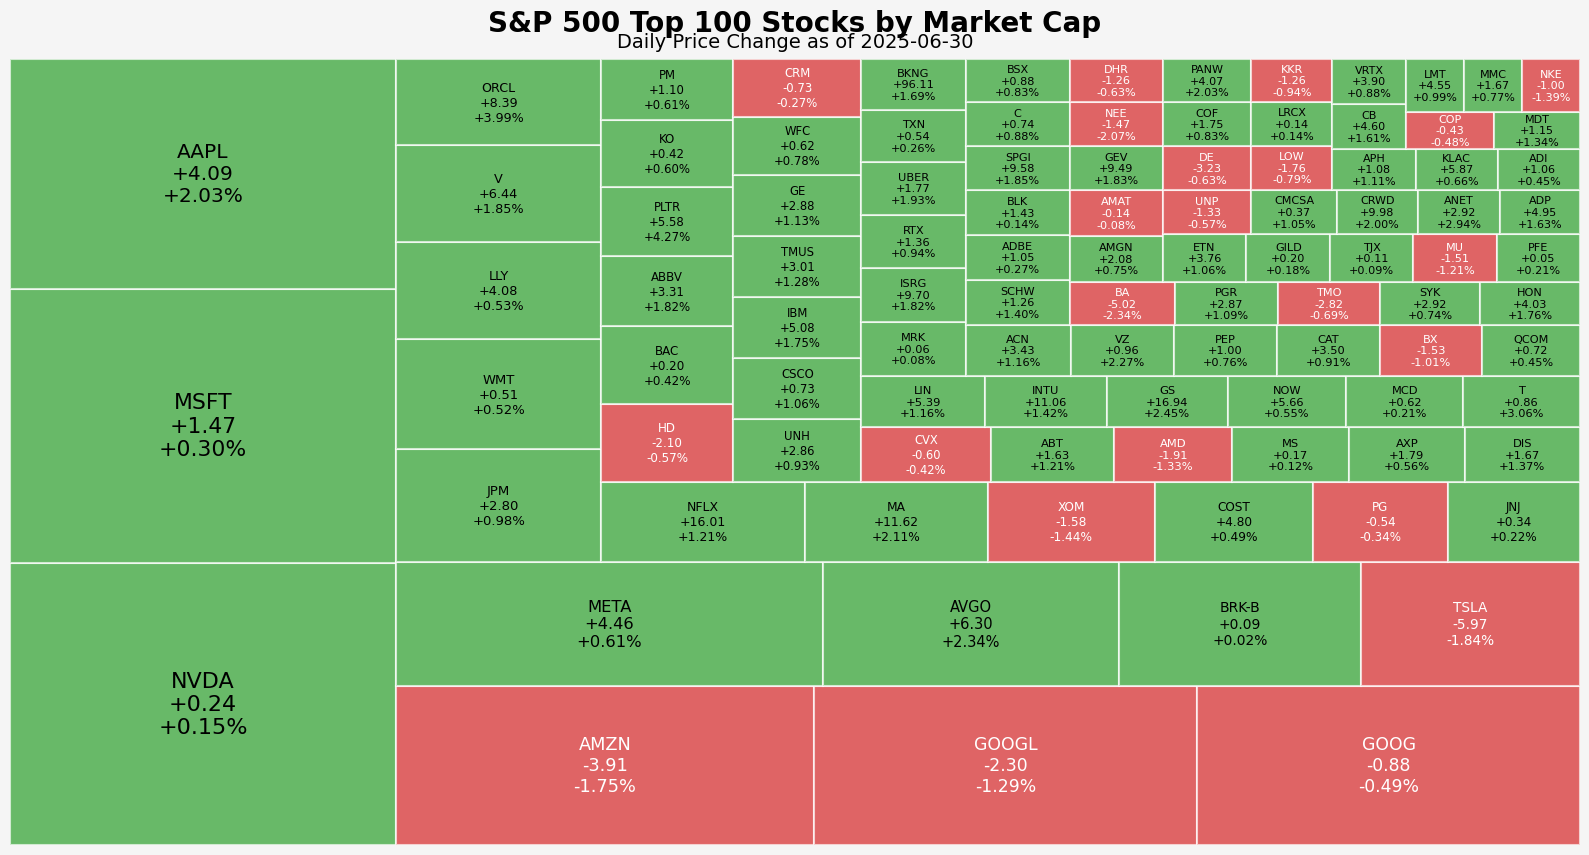

In [ ]:
import importlib.util
import subprocess
import sys

# Check and install squarify if not present
if importlib.util.find_spec("squarify") is None:
    print("[Debug] *****squarify not found. Installing squarify...*****")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "squarify"])
else:
    print("[Debug] *****squarify is already installed.*****")

# Imports
import numpy as np
import yfinance as yf
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
from io import StringIO
import squarify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import holidays

# Settings
pd.options.mode.chained_assignment = None
np.set_printoptions(legacy='1.25')

def get_sp500_list():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    try:
        response = requests.get(url)
        response.raise_for_status()
        tables = pd.read_html(StringIO(response.text))
        sp500_df = tables[0]
        sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK']]
        sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-', regex=False)
        return sp500_df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except ValueError as e:
        print(f"Error parsing table: {e}")
        return None

def get_closing_price_and_market_cap(ticker, date=(datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d'), max_attempts=5):
    try:
        date_obj = pd.to_datetime(date)
        us_holidays = holidays.US(years=date_obj.year)
        for attempt in range(max_attempts):
            if date_obj in us_holidays or date_obj.weekday() >= 5:
                date_obj -= timedelta(days=1)
                continue
            next_day = date_obj + pd.Timedelta(days=1)
            stock = yf.Ticker(ticker)
            hist = stock.history(start=date_obj.strftime('%Y-%m-%d'), end=next_day.strftime('%Y-%m-%d'))
            if not hist.empty:
                closing_price = hist['Close'].values[0]
                info = stock.info
                market_cap = info.get('marketCap', 'N/A')
                return [ticker, date_obj.strftime('%Y-%m-%d'), closing_price, market_cap]
            date_obj -= timedelta(days=1)
        return f"No data available for {ticker} on {date} after {max_attempts} attempts (market may have been closed)."
    except Exception as e:
        return f"An error occurred for {ticker}: {e}"

def get_dates():
    us_holidays = holidays.US(years=datetime.today().year)
    today = datetime.today() - timedelta(days=1)
    date1 = today
    while date1.weekday() >= 5 or date1 in us_holidays:
        date1 -= timedelta(days=1)
    date2 = date1 - timedelta(days=1)
    while date2.weekday() >= 5 or date2 in us_holidays:
        date2 -= timedelta(days=1)
    return date1.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d')

# Main execution
td, ld = get_dates()
sp500_df = get_sp500_list()

tickers = []
current_dates = []
current_closes = []
previous_closes = []
market_caps = []

for t in sp500_df['Symbol'].values:
    prev_data = get_closing_price_and_market_cap(t, ld)
    curr_data = get_closing_price_and_market_cap(t, td)
    if isinstance(prev_data, list) and isinstance(curr_data, list):
        tickers.append(t)
        current_dates.append(td)
        current_closes.append(curr_data[2])
        previous_closes.append(prev_data[2])
        market_caps.append(curr_data[3])

result_df = pd.DataFrame({
    'Ticker': tickers,
    'Current_Date': current_dates,
    'Current_Close': current_closes,
    'Previous_Close': previous_closes,
    'Market_Cap': market_caps
})

result_df['Price_Diff'] = result_df['Current_Close'] - result_df['Previous_Close']
result_df['Price_Change_%'] = ((result_df['Price_Diff'] / result_df['Previous_Close']) * 100).round(2)
result_df = result_df.sort_values(by='Market_Cap', ascending=False)

# Filter top 100 stocks by Market_Cap
top_df = result_df.nlargest(100, 'Market_Cap')
top_df['Market_Cap'] = top_df['Market_Cap'].clip(lower=1)

sizes = top_df['Market_Cap'].values
labels = top_df.apply(
    lambda x: f"{x['Ticker']}\n{x['Price_Diff']:+.2f}\n{x['Price_Change_%']:+.2f}%",
    axis=1
)

# Enhanced color scheme
colors = []
for change in top_df['Price_Change_%']:
    if change >= 5:
        colors.append('#006400')  # Deep green
    elif change <= -5:
        colors.append('#8B0000')  # Deep red
    elif change >= 0:
        colors.append('#2ca02c')  # Standard green
    else:
        colors.append('#d62728')  # Standard red

# Calculate font sizes
min_font, max_font = 8, 16
norm_sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-10)
font_sizes = min_font + (max_font - min_font) * norm_sizes

# Create the treemap
plt.figure(figsize=(16, 9), facecolor='#f5f5f5')
squarify.plot(
    sizes=sizes,
    color=colors,
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5,
    pad=False
)

# Add labels
for i, rect in enumerate(plt.gca().patches):
    x, y, width, height = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
    label = labels.iloc[i]
    fontsize = font_sizes[i]
    price_change = top_df['Price_Change_%'].iloc[i]
    text_color = 'white' if price_change < 0 else 'black'
    plt.text(
        x + width / 2, y + height / 2, label,
        ha='center', va='center',
        fontsize=fontsize,
        fontfamily='DejaVu Sans',
        color=text_color,
        wrap=True,
        bbox=dict(facecolor='none', edgecolor='none', pad=2)
    )

# Final plot adjustments
plt.title('S&P 500 Top 100 Stocks by Market Cap', fontsize=20, fontweight='bold', pad=20, fontfamily='DejaVu Sans')
plt.suptitle(f'Daily Price Change as of {td}', fontsize=14, fontfamily='DejaVu Sans', y=0.92)
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2-1955944175.py:83: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_history = yf.download(self.name_ticker, period=self.data_period, progress=False, multi_level_index=False)
/tmp/ipython-input-2-1955944175.py:83: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_history = yf.download(self.name_ticker, period=self.data_period, progress=False, multi_level_index=False)


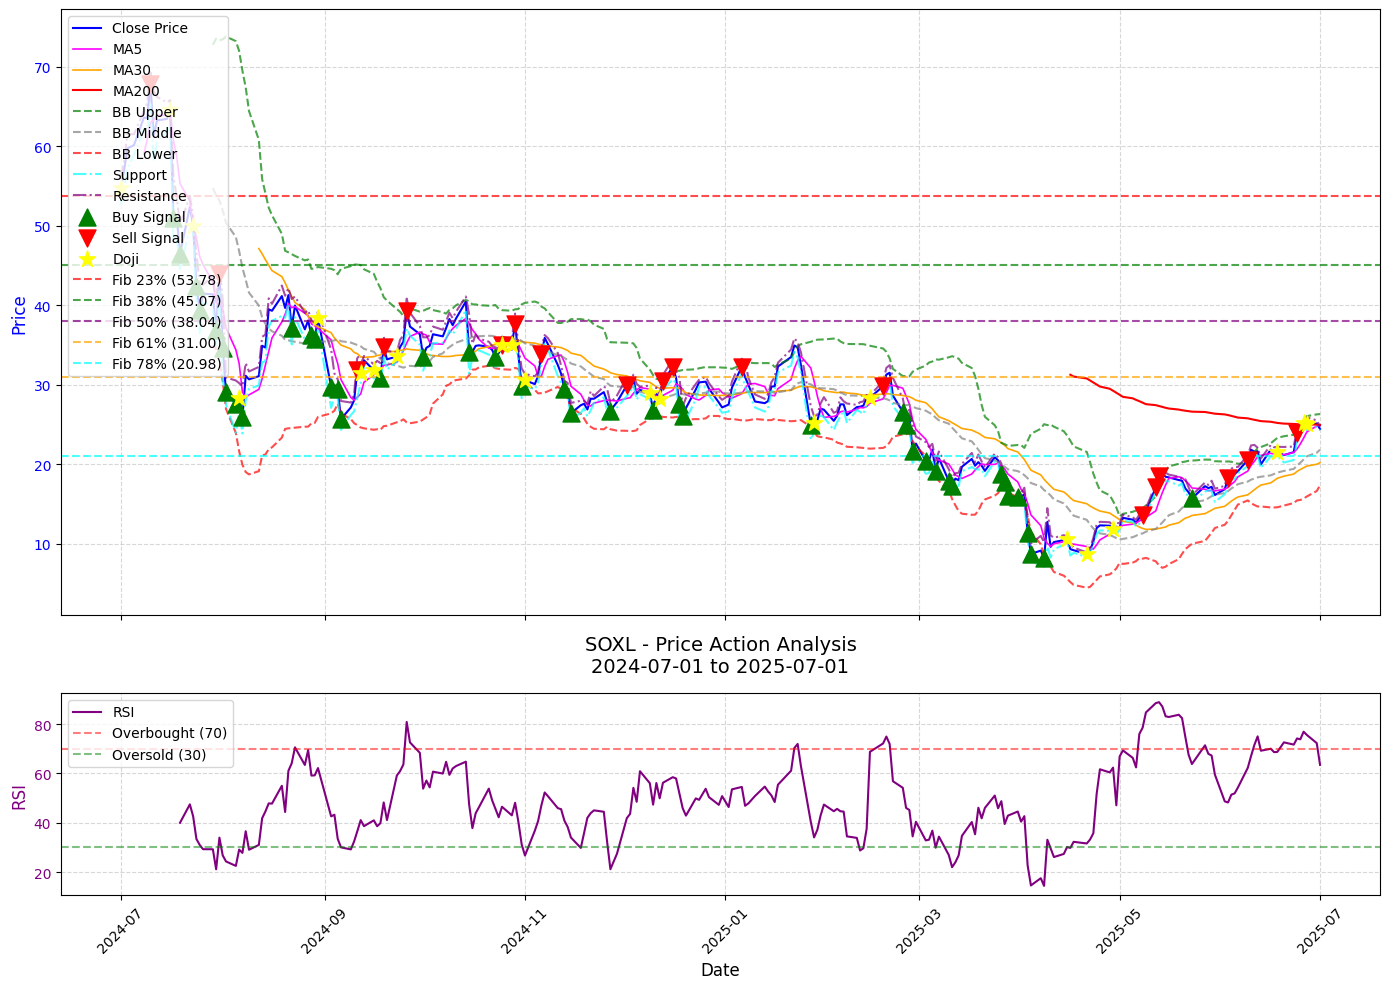

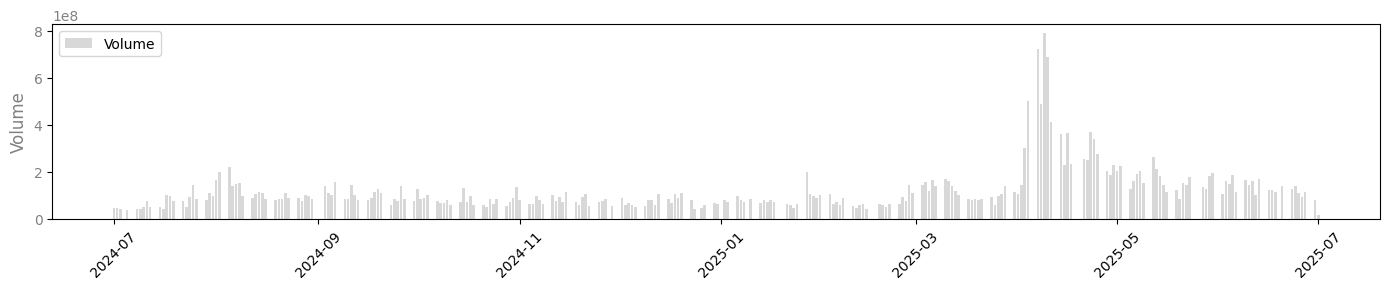

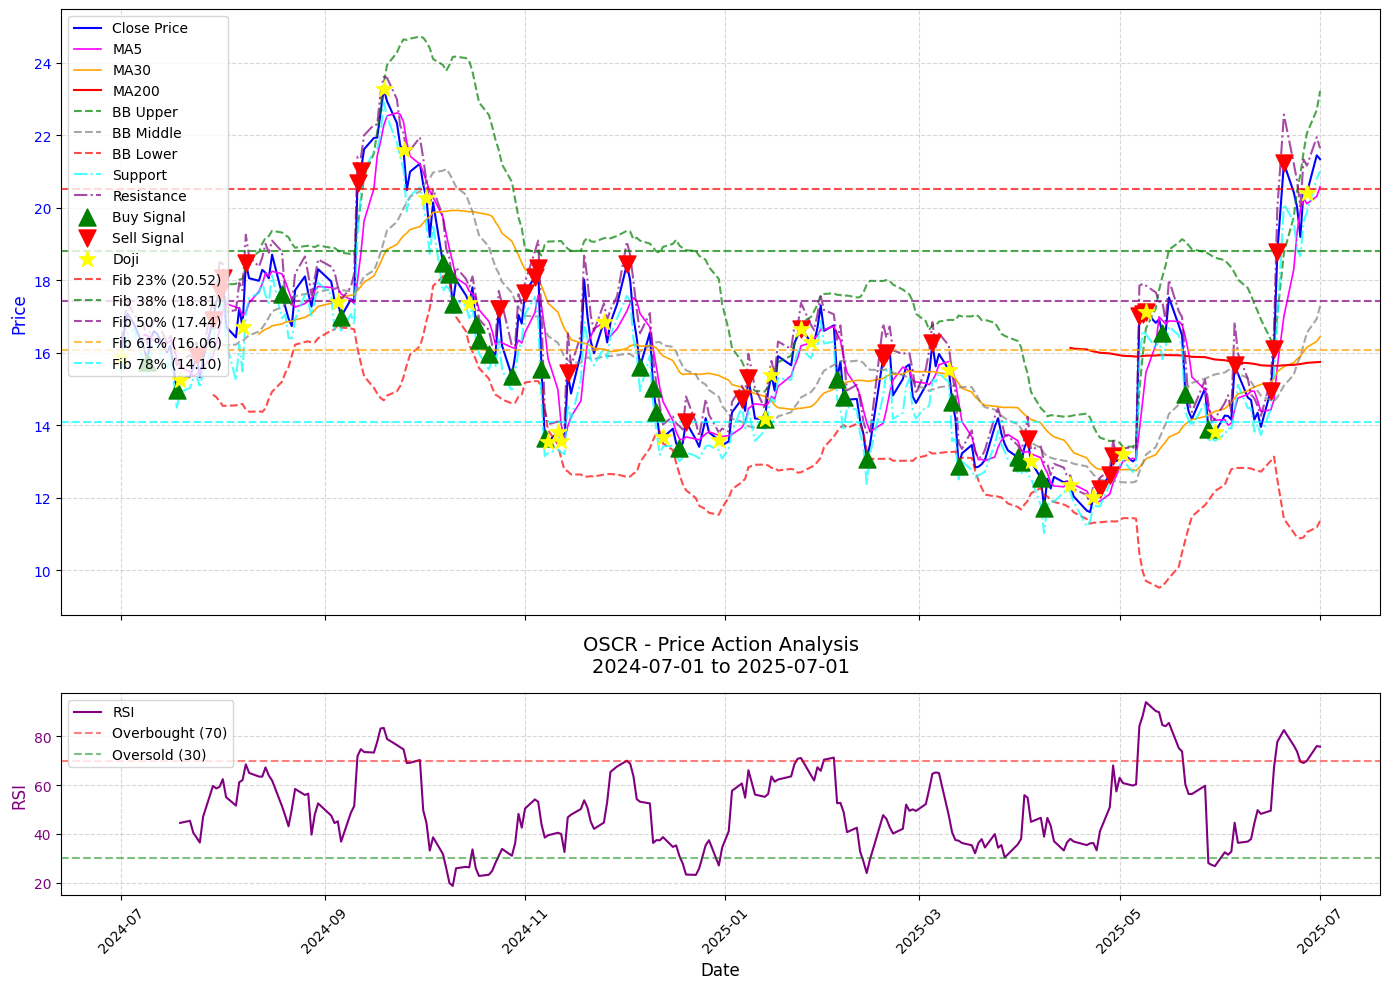

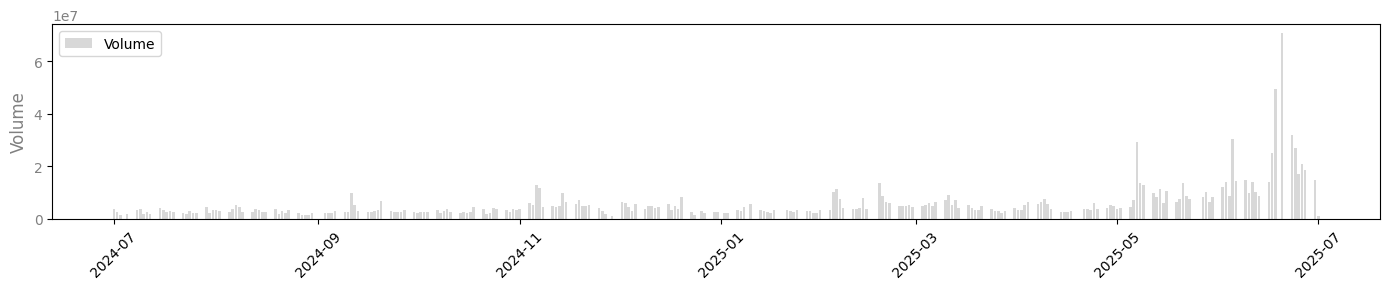

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

class Stock:
    ''' Class attribute '''
    symbol_type = "stock"
    default_data_period = '1y'

    ''' Instance attribute '''
    def __init__(self, name_ticker):
        self.name_ticker = name_ticker
        self.data_period = self.default_data_period

    ''' Class Function '''
    def set_data_period(self, data_period):
        self.data_period = data_period

    def get_current_price(self):
        try:
            ticker_data = yf.Ticker(self.name_ticker)
            if "navPrice" in ticker_data.info:
                price_quote = ticker_data.info["navPrice"]
            elif "currentPrice" in ticker_data.info:
                price_quote = ticker_data.info["currentPrice"]
            else:
                price_quote = ticker_data.info["ask"]
            return price_quote
        except:
            print("Error: Could not retrieve current price.")
            return None

    def get_current_volumn(self):
        try:
            ticker_data = yf.Ticker(self.name_ticker)
            if "volume" in ticker_data.info:
                volume_quote = ticker_data.info["volume"]
            return volume_quote
        except:
            print("Error: Could not retrieve current volume.")
            return None

    def get_price_target_date(self, target_date):
        try:
            date_obj = datetime.strptime(target_date, '%Y-%m-%d')
            target_date_plus_one = date_obj + timedelta(days=1)
            ticker_data = yf.download(self.name_ticker, start=target_date, end=target_date_plus_one, progress=False, multi_level_index=False)
            return (target_date, ticker_data['Close'])
        except:
            print(f"[Error] Could not retrieve price for target date: {target_date}.")
            return None

    def get_volume_target_date(self, target_date):
        try:
            date_obj = datetime.strptime(target_date, '%Y-%m-%d')
            target_date_plus_one = date_obj + timedelta(days=1)
            ticker_data = yf.download(self.name_ticker, start=target_date, end=target_date_plus_one, progress=False, multi_level_index=False)
            return (target_date, ticker_data['Volume'])
        except:
            print(f"[Error] Could not retrieve volume for target date: {target_date}.")
            return None

    def get_price_history(self):
        try:
            ticker_data = yf.download(self.name_ticker, period=self.data_period, progress=False, multi_level_index=False)
            return ticker_data['Close']
        except:
            print("[Error] Could not retrieve price history.")
            return None

    def get_volume_history(self):
        try:
            ticker_data = yf.download(self.name_ticker, period=self.data_period, progress=False, multi_level_index=False)
            return ticker_data['Volume']
        except:
            print("[Error] Could not retrieve volume history.")
            return None

    def get_history_data(self):
        try:
            data_history = yf.download(self.name_ticker, period=self.data_period, progress=False, multi_level_index=False)
        except Exception as e:
            print("[Error] occurred while getting data from Yahoo Finance API.")
            print(f"Error details: {e}")
            return None
        else:
            if data_history.empty:
                print("[Error] No data found for the entered ticker symbol.")
                return None
            else:
                return data_history

    def get_stock_info_html(self):
        html = f"<p>Symbol Type: {self.symbol_type}</p>"
        html += f"<p>Ticker: {self.name_ticker}</p>"
        html += f"<p>Current Data Period: {self.data_period}</p>"
        html += f"<p>Latest Price: {self.get_current_price()}</p>"
        return html

    def __str__(self):
        return f"[***** Symbol Info *****]\nSymbol Type: {self.symbol_type}\nTicker: {self.name_ticker}\nCurrent Data Period: {self.data_period}\nLatest Price: {self.get_current_price()}\nLatest Volume: {self.get_current_volumn()}"

    def calculate_price_action_indicators(self, trend_period=5, volume_lookback=10, rsi_period=14, bb_period=20, bb_std=2):
        """
        Calculates price action indicators including RSI, Bollinger Bands, and Support/Resistance levels.
        """
        data = self.get_history_data()
        if data is None:
            return None

        df = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

        # Trend Confirmation
        df['Trend'] = np.where(df['Close'] > df['Close'].shift(trend_period), 1, np.where(df['Close'] < df['Close'].shift(trend_period), -1, 0))
        df['Avg_Volume'] = df['Volume'].rolling(window=volume_lookback, min_periods=1).mean()
        df['New_High'] = df['Close'] > df['Close'].shift(1).rolling(trend_period).max()
        df['New_Low'] = df['Close'] < df['Close'].shift(1).rolling(trend_period).min()
        df['Volume_Confirm'] = df['Volume'] > df['Avg_Volume']
        df['Signal'] = 0
        df.loc[(df['Trend'] == 1) & (df['New_High']) & (df['Volume_Confirm']), 'Signal'] = -1  # Buy
        df.loc[(df['Trend'] == -1) & (df['New_Low']) & (df['Volume_Confirm']), 'Signal'] = 1   # Sell

        # RSI Calculation
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=bb_period).mean()
        df['BB_Std'] = df['Close'].rolling(window=bb_period).std()
        df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * bb_std)
        df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * bb_std)

        # Support and Resistance (using pivot points)
        df['Pivot'] = (df['High'] + df['Low'] + df['Close']) / 3
        df['Support1'] = (2 * df['Pivot']) - df['High']
        df['Resistance1'] = (2 * df['Pivot']) - df['Low']

        # Basic Doji Candlestick Detection
        df['Doji'] = abs(df['Open'] - df['Close']) <= (df['High'] - df['Low']) * 0.1

        return df

    def plot_price_action_analysis(self, trend_period=5, volume_lookback=10, rsi_period=14, bb_period=20, bb_std=2):
        """
        Plots enhanced price action analysis with RSI, Bollinger Bands, Support/Resistance, and Doji patterns.
        """
        df = self.calculate_price_action_indicators(trend_period, volume_lookback, rsi_period, bb_period, bb_std)
        if df is None:
            return

        # Calculate moving averages
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA30'] = df['Close'].rolling(window=30).mean()
        df['MA200'] = df['Close'].rolling(window=200).mean()

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

        # Plot Close price and indicators on primary axis
        ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=1.5)
        ax1.plot(df.index, df['MA5'], label='MA5', color='magenta', linewidth=1.2)
        ax1.plot(df.index, df['MA30'], label='MA30', color='orange', linewidth=1.2)
        ax1.plot(df.index, df['MA200'], label='MA200', color='red', linewidth=1.5)

        # Plot Bollinger Bands
        ax1.plot(df.index, df['BB_Upper'], label='BB Upper', color='green', linestyle='--', alpha=0.7)
        ax1.plot(df.index, df['BB_Middle'], label='BB Middle', color='gray', linestyle='--', alpha=0.7)
        ax1.plot(df.index, df['BB_Lower'], label='BB Lower', color='red', linestyle='--', alpha=0.7)

        # Plot Support and Resistance
        ax1.plot(df.index, df['Support1'], label='Support', color='cyan', linestyle='-.', alpha=0.7)
        ax1.plot(df.index, df['Resistance1'], label='Resistance', color='purple', linestyle='-.', alpha=0.7)

        # Plot Buy/Sell signals
        buy_signals = df[df['Signal'] == 1]
        sell_signals = df[df['Signal'] == -1]
        ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=150, zorder=5)
        ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=150, zorder=5)

        # Plot Doji patterns
        doji_signals = df[df['Doji'] == True]
        ax1.scatter(doji_signals.index, doji_signals['Close'], marker='*', color='yellow', label='Doji', s=150, zorder=5)

        # Calculate Fibonacci retracement levels
        max_price = df['Close'].max()
        min_price = df['Close'].min()
        diff_price = max_price - min_price
        fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
        retracement_levels = [max_price - level * diff_price for level in fib_levels]
        level_labels = [f'{int(level*100)}%' for level in fib_levels]

        # Plot Fibonacci levels
        colors = ['red', 'green', 'purple', 'orange', 'cyan']
        for level, label, color in zip(retracement_levels, level_labels, colors):
            ax1.axhline(y=level, linestyle='--', alpha=0.7, color=color, label=f'Fib {label} ({level:.2f})')

        # Customize primary axis
        ax1.set_ylabel('Price', fontsize=12, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, linestyle='--', alpha=0.5)
        ax1.legend(loc='upper left', fontsize=10)

        # Plot RSI on secondary axis
        ax2.plot(df.index, df['RSI'], label='RSI', color='purple', linewidth=1.5)
        ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
        ax2.set_ylabel('RSI', fontsize=12, color='purple')
        ax2.tick_params(axis='y', labelcolor='purple')
        ax2.legend(loc='upper left', fontsize=10)
        ax2.grid(True, linestyle='--', alpha=0.5)

        # Customize the plot
        start_date = df.index[0].strftime('%Y-%m-%d')
        end_date = df.index[-1].strftime('%Y-%m-%d')
        plt.title(f'{self.name_ticker} - Price Action Analysis\n{start_date} to {end_date}', fontsize=14, pad=15)
        plt.xlabel('Date', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Add volume subplot
        fig, ax3 = plt.subplots(figsize=(14, 3))
        ax3.bar(df.index, df['Volume'], alpha=0.3, color='gray', label='Volume')
        ax3.set_ylabel('Volume', fontsize=12, color='gray')
        ax3.tick_params(axis='y', labelcolor='gray')
        ax3.legend(loc='upper left', fontsize=10)
        plt.xticks(rotation=45)
        plt.tight_layout()

### MAIN #####
if __name__ == "__main__":
    tk_list = ['NBIS', 'VOO', 'QQQ', 'PLTR', 'TSLA', 'AAPL', 'DXYZ', 'BA', 'WDAY', 'APP', 'COST', 'NVDA', 'TSM', 'TQQQ', 'SQQQ', 'HOOD', 'ONDS', 'UAL', 'GEV', 'META', 'AVGO']
    tk_list = ['SOXL','OSCR']
    for name_ticker in tk_list:
        s = Stock(name_ticker)
        s.plot_price_action_analysis(trend_period=5, volume_lookback=10, rsi_period=14, bb_period=20, bb_std=2)

/tmp/ipython-input-1-3842186809.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(symbol, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


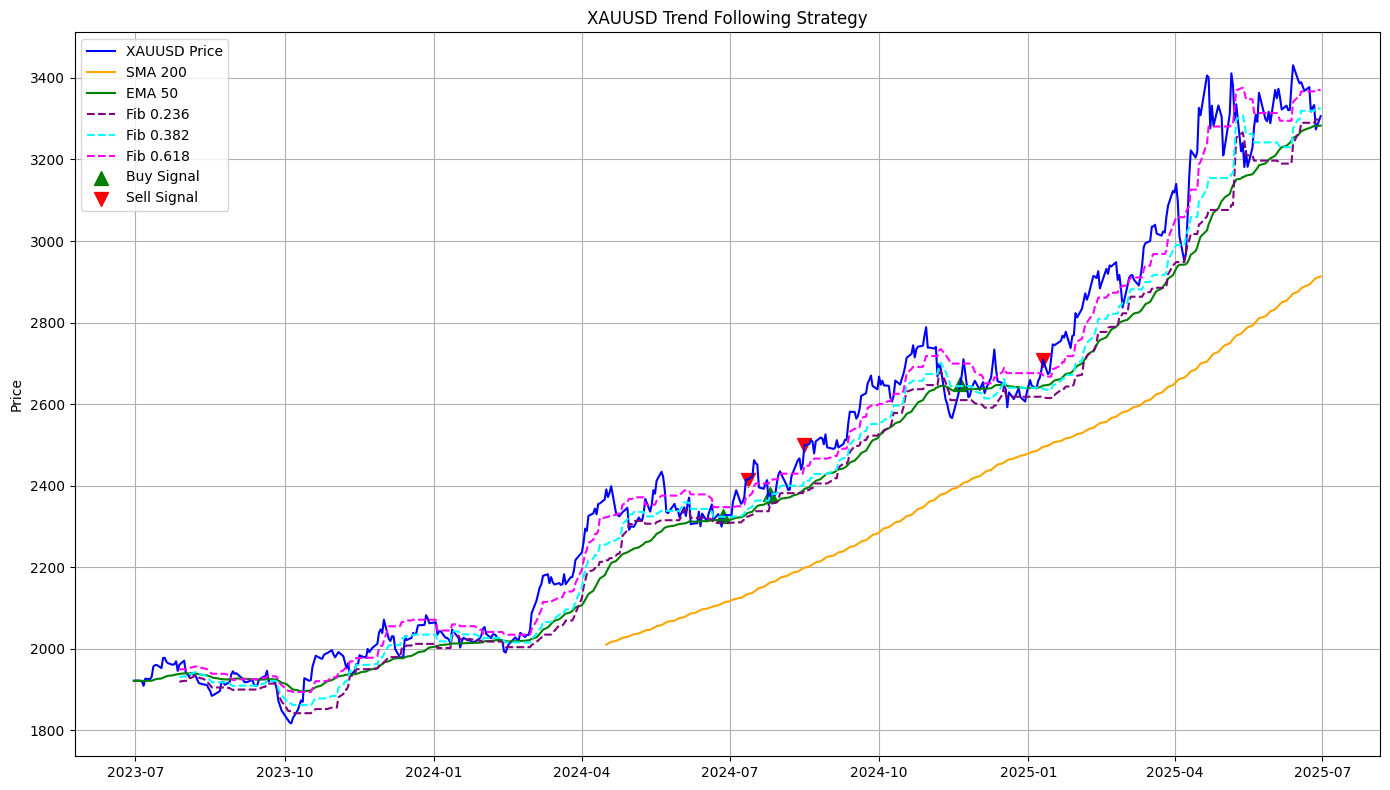

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch XAUUSD data
def fetch_data(symbol="GC=F", period="2y", interval="1d"):
    return yf.download(symbol, period=period, interval=interval)

# Calculate SMAs, EMAs, RSI, and Fibonacci levels
def calculate_indicators(data):
    # Moving averages
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

    # RSI
    def calculate_rsi(data, periods=14):
        delta = data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=periods).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=periods).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    data['RSI'] = calculate_rsi(data)

    # Fibonacci levels
    def calculate_fibonacci_levels(data, window=20):
        fib_levels = [0.236, 0.382, 0.618]
        rolling_high = data['High'].rolling(window=window).max()
        rolling_low = data['Low'].rolling(window=window).min()
        range_ = rolling_high - rolling_low

        for level in fib_levels:
            data[f'Fib_{level}'] = rolling_low + range_ * level
        return data

    return calculate_fibonacci_levels(data)

# Generate trading signals
def generate_signals(data):
    signals = [0] * len(data)
    position = 0  # 0: no position, 1: long, -1: short

    for i in range(1, len(data)):
        price = data['Close'].values[i]
        prev_price = data['Close'].values[i-1]
        sma_200 = data['SMA_200'].values[i]
        ema_50 = data['EMA_50'].values[i]
        prev_ema_50 = data['EMA_50'].values[i-1]
        fib_0_382 = data['Fib_0.382'].values[i]
        rsi = data['RSI'].values[i]

        # Buy signal
        if (price > sma_200 and prev_price <= prev_ema_50 and price > ema_50 and price >= fib_0_382 and rsi < 70 and position != 1):
            signals[i] = 1
            position = 1
        # Sell signal
        elif (price < sma_200 and prev_price >= prev_ema_50 and
              price < ema_50 and price <= fib_0_382 and rsi > 30 and position != -1):
            signals[i] = -1
            position = -1
        # Exit long
        elif position == 1 and (rsi > 70 or price < sma_200):
            signals[i] = -1
            position = 0
        # Exit short
        elif position == -1 and (rsi < 30 or price > sma_200):
            signals[i] = 1
            position = 0

    data['Signal'] = signals
    return data

# Plot results
def plot_results(data):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot price and indicators
    ax.plot(data.index, data['Close'], label='XAUUSD Price', color='blue')
    ax.plot(data.index, data['SMA_200'], label='SMA 200', color='orange')
    ax.plot(data.index, data['EMA_50'], label='EMA 50', color='green')
    ax.plot(data.index, data['Fib_0.236'], label='Fib 0.236', color='purple', linestyle='--')
    ax.plot(data.index, data['Fib_0.382'], label='Fib 0.382', color='cyan', linestyle='--')
    ax.plot(data.index, data['Fib_0.618'], label='Fib 0.618', color='magenta', linestyle='--')

    # Plot buy/sell signals
    buy_signals = data[data['Signal'] == 1]
    sell_signals = data[data['Signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
    ax.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

    ax.set_title('XAUUSD Trend Following Strategy')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    data = fetch_data()
    data = calculate_indicators(data)
    data = generate_signals(data)
    plot_results(data)

/tmp/ipython-input-3-643333123.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


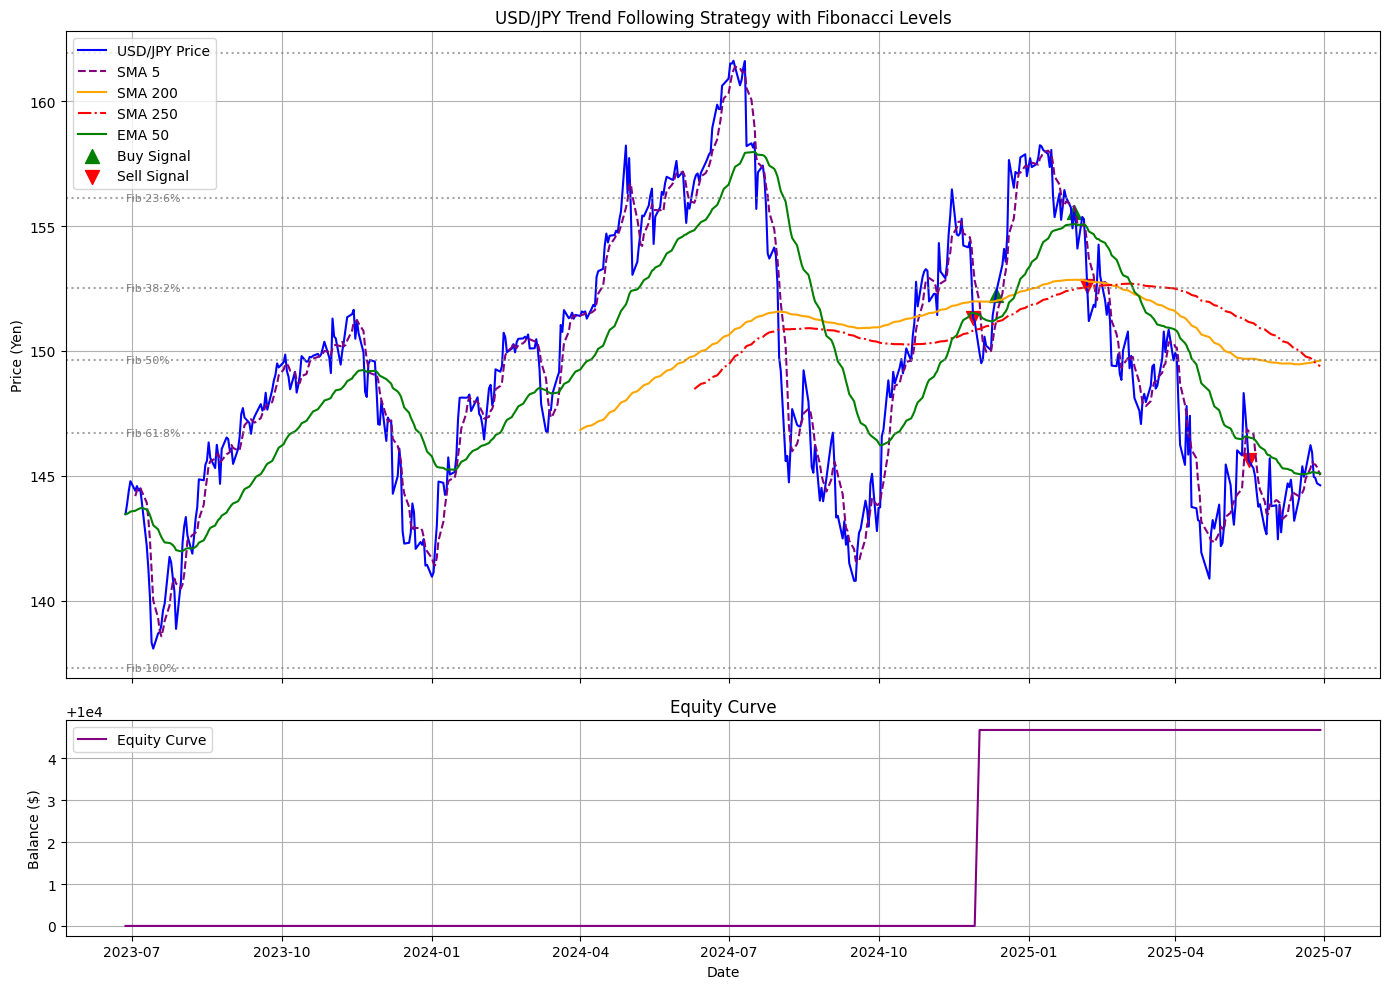

Initial Balance: $10000.00
Final Balance: $10,004.68
Total Return: [0.04677179]%
Number of Trades: 5


/tmp/ipython-input-3-643333123.py:215: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Final Balance: ${float(final_balance):,.2f}")


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

# Fetch JPYUSD data (using USD/JPY ticker)
def fetch_data(symbol="JPY=X", period="2y", interval="1d"):
    data = yf.download(symbol, period=period, interval=interval)
    return data

# Calculate SMAs, EMAs, and Fibonacci levels
def calculate_indicators(data):
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['SMA_250'] = data['Close'].rolling(window=250).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

    # Calculate Fibonacci retracement levels
    high_price = data['High'].max()
    low_price = data['Low'].min()
    price_range = high_price - low_price

    fib_levels = {
        '0%': high_price,
        '23.6%': high_price - 0.236 * price_range,
        '38.2%': high_price - 0.382 * price_range,
        '50%': high_price - 0.5 * price_range,
        '61.8%': high_price - 0.618 * price_range,
        '100%': low_price
    }

    return data, fib_levels

# Generate trading signals
def generate_signals(data):
    signals = []
    position = 0  # 0: no position, 1: long, -1: short

    for i in range(1, len(data)):
        price = data['Close'].values[i]
        prev_price = data['Close'].values[i-1]
        sma_200 = data['SMA_200'].values[i]
        ema_50 = data['EMA_50'].values[i]
        prev_ema_50 = data['EMA_50'].values[i-1]

        # Buy signal: Price above SMA_200, pulls back to EMA_50, and shows bullish confirmation
        if (price > sma_200 and prev_price <= prev_ema_50 and price > ema_50 and position != 1):
            signals.append(1)  # Buy
            position = 1
        # Sell signal: Price below SMA_200, rallies to EMA_50, and shows bearish confirmation
        elif (price < sma_200 and prev_price >= prev_ema_50 and price < ema_50 and position != -1):
            signals.append(-1)  # Sell
            position = -1
        else:
            signals.append(0)  # No trade
            if position == 1 and price < sma_200:  # Exit long if price falls below SMA_200
                position = 0
                signals[-1] = -1
            elif position == -1 and price > sma_200:  # Exit short if price rises above SMA_200
                position = 0
                signals[-1] = 1

    # Add initial signal to align with data length
    signals.insert(0, 0)
    data['Signal'] = signals
    return data

# Backtest the strategy
def backtest_strategy(data, initial_balance=10000, risk_per_trade=0.02):
    balance = initial_balance
    position = 0  # 0: no position, 1: long, -1: short
    trades = []
    equity_curve = []

    for i in range(1, len(data)):
        signal = data['Signal'].values[i]
        price = data['Close'].values[i]
        sma_200 = data['SMA_200'].values[i]

        # Execute trades
        if signal == 1 and position == 0:  # Buy
            position = 1
            entry_price = price
            stop_loss = price - 0.50  # 50 pips (0.50 yen)
            take_profit = price + 1.00  # 100 pips (1.00 yen)
            trades.append({'Type': 'Buy', 'Entry': entry_price, 'Stop_Loss': stop_loss, 'Take_Profit': take_profit})
        elif signal == -1 and position == 1:  # Exit long
            position = 0
            exit_price = price
            profit = (exit_price - trades[-1]['Entry']) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit
        elif signal == -1 and position == 0:  # Sell (short)
            position = -1
            entry_price = price
            stop_loss = price + 0.50  # 50 pips (0.50 yen)
            take_profit = price - 1.00  # 100 pips (1.00 yen)
            trades.append({'Type': 'Sell', 'Entry': entry_price, 'Stop_Loss': stop_loss, 'Take_Profit': take_profit})
        elif signal == 1 and position == -1:  # Exit short
            position = 0
            exit_price = price
            profit = (trades[-1]['Entry'] - exit_price) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit

        # Check stop-loss/take-profit
        if position == 1 and price <= trades[-1]['Stop_Loss']:
            position = 0
            exit_price = trades[-1]['Stop_Loss']
            profit = (exit_price - trades[-1]['Entry']) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit
        elif position == 1 and price >= trades[-1]['Take_Profit']:
            position = 0
            exit_price = trades[-1]['Take_Profit']
            profit = (exit_price - trades[-1]['Entry']) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit
        elif position == -1 and price >= trades[-1]['Stop_Loss']:
            position = 0
            exit_price = trades[-1]['Stop_Loss']
            profit = (trades[-1]['Entry'] - exit_price) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit
        elif position == -1 and price <= trades[-1]['Take_Profit']:
            position = 0
            exit_price = trades[-1]['Take_Profit']
            profit = (trades[-1]['Entry'] - exit_price) / trades[-1]['Entry'] * balance * risk_per_trade
            balance += profit
            trades[-1]['Exit'] = exit_price
            trades[-1]['Profit'] = profit

        equity_curve.append(balance)

    # Add initial balance to equity curve
    equity_curve.insert(0, initial_balance)
    data['Equity'] = equity_curve
    return data, trades, balance

# Plot results
def plot_results(data, trades, fib_levels):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot price, SMAs, and EMA
    ax1.plot(data.index, data['Close'], label='USD/JPY Price', color='blue')
    ax1.plot(data.index, data['SMA_5'], label='SMA 5', color='purple', linestyle='--')
    ax1.plot(data.index, data['SMA_200'], label='SMA 200', color='orange')
    ax1.plot(data.index, data['SMA_250'], label='SMA 250', color='red', linestyle='-.')
    ax1.plot(data.index, data['EMA_50'], label='EMA 50', color='green')

    # Plot buy/sell signals
    buy_signals = data[data['Signal'] == 1]
    sell_signals = data[data['Signal'] == -1]
    ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
    ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

    # Plot Fibonacci retracement levels
    for k in fib_levels:
      #print (k, fib_levels[k].values[0])

        level=k
        price=fib_levels[k].values[0]

        ax1.axhline(y=price, color='gray', linestyle=':', alpha=0.7)
        ax1.text(data.index[0], price, f'Fib {level}', verticalalignment='center', color='gray', fontsize=8)

    ax1.set_title('USD/JPY Trend Following Strategy with Fibonacci Levels')
    ax1.set_ylabel('Price (Yen)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot equity curve
    ax2.plot(data.index, data['Equity'], label='Equity Curve', color='purple')
    ax2.set_title('Equity Curve')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Balance ($)')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()

# Main execution
if __name__ == "__main__":
    # Fetch data
    data = fetch_data(symbol="JPY=X", period="2y", interval="1d")

    # Calculate indicators and Fibonacci levels
    data, fib_levels = calculate_indicators(data)

    # Generate signals
    data = generate_signals(data)

    # Backtest
    data, trades, final_balance = backtest_strategy(data)

    # Plot results
    plot_results(data, trades, fib_levels)

    # Print performance metrics
    initial_balance = 10000
    total_return = (final_balance - initial_balance) / initial_balance * 100

    print(f"Initial Balance: ${initial_balance:.2f}")
    print(f"Final Balance: ${float(final_balance):,.2f}")
    print(f"Total Return: {total_return}%")
    print(f"Number of Trades: {len(trades)}")

In [ ]:
# ! pip install --upgrade yfinance
! pip install squarify


Weekly Signals for AAPL (Open Price vs. 1 and 2 STD Bollinger Bands at Close):
                                 Open       Close            Signal
Date                                                               
2020-07-05 00:00:00-04:00   89.393906   88.485016           Neutral
2020-07-12 00:00:00-04:00   89.916387   93.240852           Neutral
2020-07-19 00:00:00-04:00   94.548302   93.636978           Neutral
2020-07-26 00:00:00-04:00   93.724459   90.028191           Neutral
2020-08-02 00:00:00-04:00   91.092583  103.292053           Neutral
2020-08-09 00:00:00-04:00  105.177887  108.203789           Neutral
2020-08-16 00:00:00-04:00  109.652325  111.899422           Neutral
2020-08-23 00:00:00-04:00  113.024189  121.114220           Neutral
2020-08-30 00:00:00-04:00  125.328417  121.540268           Neutral
2020-09-06 00:00:00-04:00  124.240170  117.793472           Neutral
2020-09-13 00:00:00-04:00  110.966978  109.068031           Neutral
2020-09-20 00:00:00-04:00  111.71682

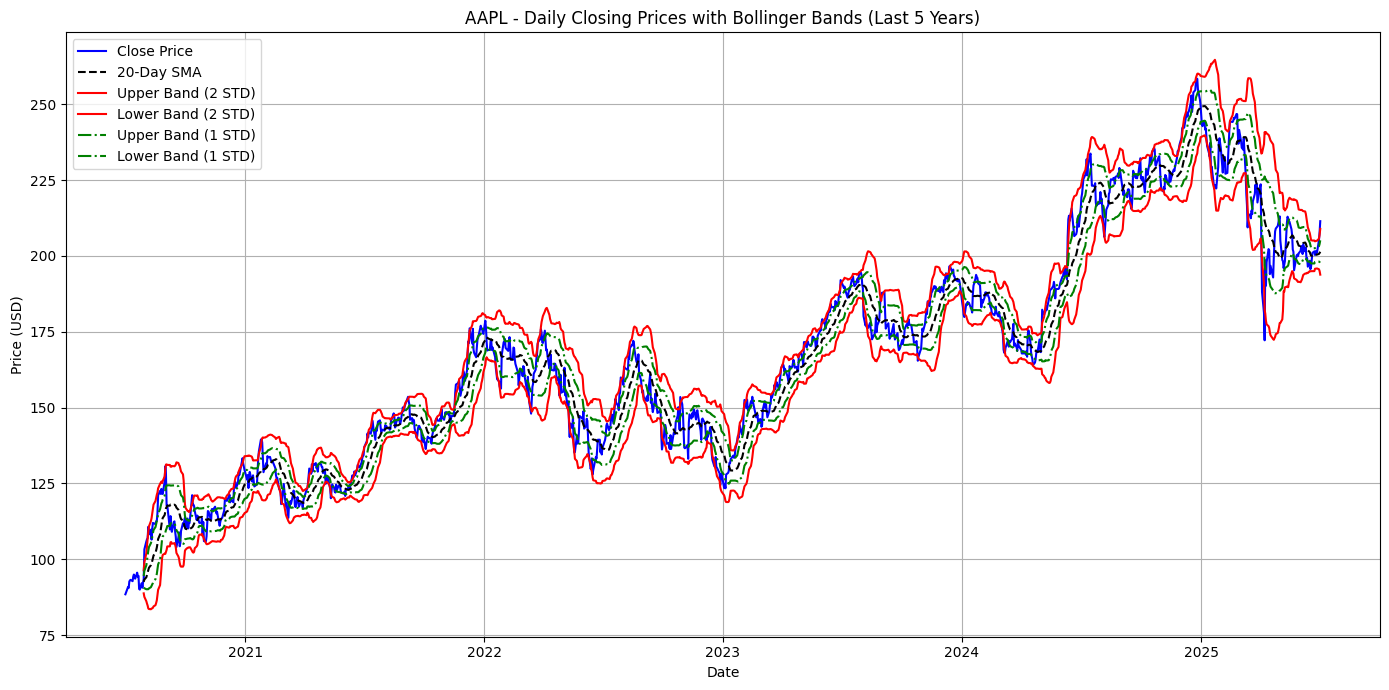

Plot saved as AAPL_bollinger_bands.png


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands for the given data.

    Args:
        data (pd.Series): Series of closing prices
        window (int): Rolling window for SMA and STD (default: 20)
        num_std (int): Number of standard deviations (default: 2)

    Returns:
        tuple: (SMA, upper_band, lower_band)
    """
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return sma, upper_band, lower_band

def generate_weekly_signals(data, window=20, num_std_1=1, num_std_2=2):
    """
    Generate signals based on whether the weekly opening price is above or below
    the 1 STD and 2 STD Bollinger Bands at the week's closing.

    Args:
        data (pd.DataFrame): DataFrame with 'Open' and 'Close' prices
        window (int): Rolling window for Bollinger Bands
        num_std_1 (int): Number of standard deviations for 1 STD bands
        num_std_2 (int): Number of standard deviations for 2 STD bands

    Returns:
        tuple: (weekly_data with signals, sma, upper_2std, lower_2std, upper_1std, lower_1std)
    """
    # Resample to weekly data, taking first Open and last Close of each week
    weekly_data = data.resample('W').agg({'Open': 'first', 'Close': 'last'})

    # Calculate Bollinger Bands on weekly closing prices for 1 STD and 2 STD
    sma, upper_2std, lower_2std = calculate_bollinger_bands(weekly_data['Close'], window=window, num_std=num_std_2)
    _, upper_1std, lower_1std = calculate_bollinger_bands(weekly_data['Close'], window=window, num_std=num_std_1)

    # Initialize signals column
    weekly_data['Signal'] = 'Neutral'

    # Generate signals for 2 STD
    weekly_data.loc[weekly_data['Open'] > upper_2std, 'Signal'] = 'Above Upper 2STD'
    weekly_data.loc[weekly_data['Open'] < lower_2std, 'Signal'] = 'Below Lower 2STD'

    # Generate signals for 1 STD (only if not already flagged by 2 STD)
    weekly_data.loc[(weekly_data['Open'] > upper_1std) & (weekly_data['Signal'] == 'Neutral'), 'Signal'] = 'Above Upper 1STD'
    weekly_data.loc[(weekly_data['Open'] < lower_1std) & (weekly_data['Signal'] == 'Neutral'), 'Signal'] = 'Below Lower 1STD'

    return weekly_data[['Open', 'Close', 'Signal']], sma, upper_2std, lower_2std, upper_1std, lower_1std

def summarize_yearly_signals(weekly_data):
    """
    Summarize the count of each signal type by year.

    Args:
        weekly_data (pd.DataFrame): DataFrame with weekly signals

    Returns:
        pd.DataFrame: Summary table with counts of each signal type per year
    """
    # Extract year from index
    weekly_data['Year'] = weekly_data.index.year

    # Group by year and count each signal type
    summary = weekly_data.groupby(['Year', 'Signal']).size().unstack(fill_value=0)

    # Ensure all signal types are present in the summary
    signal_types = ['Above Upper 1STD', 'Above Upper 2STD', 'Below Lower 1STD', 'Below Lower 2STD', 'Neutral']
    for signal in signal_types:
        if signal not in summary.columns:
            summary[signal] = 0

    # Reorder columns for clarity
    summary = summary[signal_types]

    return summary

def plot_stock_with_bollinger(ticker):
    """
    Fetch 5 years of daily stock data, plot closing prices with Bollinger Bands (1 and 2 STDs),
    display weekly signals for open price relative to 1 and 2 STD bands, and summarize signals by year.

    Args:
        ticker (str): Stock ticker symbol
    """
    try:
        # Fetch 5 years of daily data
        stock = yf.Ticker(ticker)
        data = stock.history(period="5y", interval="1d")

        if data.empty:
            print(f"No data found for {ticker}")
            return

        # Extract closing prices for daily plot
        close_prices = data['Close']

        # Calculate Bollinger Bands for 1 STD and 2 STDs on daily data
        sma, upper_2std, lower_2std = calculate_bollinger_bands(close_prices, window=20, num_std=2)
        _, upper_1std, lower_1std = calculate_bollinger_bands(close_prices, window=20, num_std=1)

        # Generate weekly signals
        weekly_data, weekly_sma, weekly_upper_2std, weekly_lower_2std, weekly_upper_1std, weekly_lower_1std = generate_weekly_signals(data)

        # Print weekly signals
        print(f"\nWeekly Signals for {ticker} (Open Price vs. 1 and 2 STD Bollinger Bands at Close):")
        print(weekly_data[['Open', 'Close', 'Signal']].to_string())

        # Generate and print yearly summary table
        yearly_summary = summarize_yearly_signals(weekly_data)
        print(f"\nYearly Summary of Signals for {ticker}:")
        print(yearly_summary.to_string())

        # Plotting daily data with Bollinger Bands
        plt.figure(figsize=(14, 7))
        plt.plot(close_prices.index, close_prices, label='Close Price', color='blue')
        plt.plot(sma.index, sma, label='20-Day SMA', color='black', linestyle='--')
        plt.plot(upper_2std.index, upper_2std, label='Upper Band (2 STD)', color='red', linestyle='-')
        plt.plot(lower_2std.index, lower_2std, label='Lower Band (2 STD)', color='red', linestyle='-')
        plt.plot(upper_1std.index, upper_1std, label='Upper Band (1 STD)', color='green', linestyle='-.')
        plt.plot(lower_1std.index, lower_1std, label='Lower Band (1 STD)', color='green', linestyle='-.')

        # Customize plot
        plt.title(f'{ticker} - Daily Closing Prices with Bollinger Bands (Last 5 Years)')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save and show plot
        plt.savefig(f'{ticker}_bollinger_bands.png')
        plt.show()

        print(f"Plot saved as {ticker}_bollinger_bands.png")

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Read ticker from stdin
tickers = ['AAPL']
for t in tickers:
    ticker = t
    if ticker:
        plot_stock_with_bollinger(ticker)
    break  # Process only the first valid ticker